# Previsão Passageiros

## Leitura de dados

In [105]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
mpl.rcParams['figure.figsize']=(10,6)
mpl.rcParams['font.size']=22
sns.set_style('darkgrid')

In [2]:
passageiros = pd.read_csv('Passageiros.csv')

In [3]:
passageiros.head()

,tempo,passageiros
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121


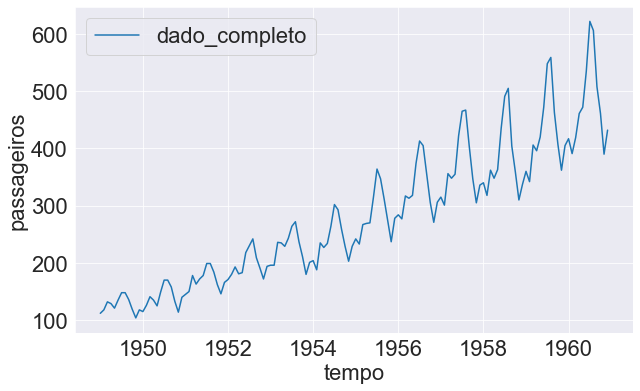

In [10]:
sns.lineplot(x='tempo',y='passageiros',data=passageiros, label='dado_completo')
plt.show()

## Pre processamento

### Normalização

In [11]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
scaler.fit(passageiros)

StandardScaler()

In [15]:
passageiros_scaled = scaler.transform(passageiros)

In [16]:
X = passageiros_scaled[:,0]
y = passageiros_scaled[:,1]

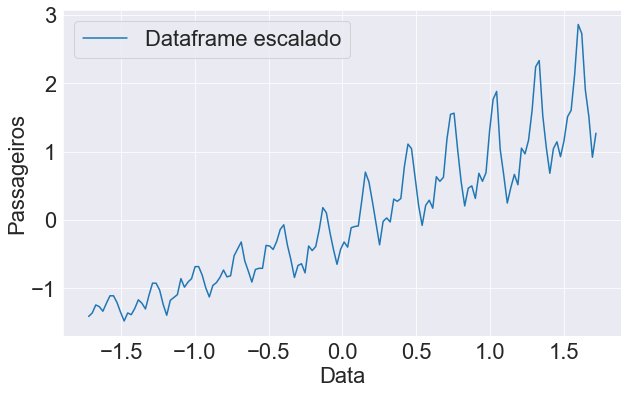

In [19]:
sns.lineplot(x=X,y=y,label='Dataframe escalado')
plt.ylabel("Passageiros")
plt.xlabel("Data")
plt.show()

### Treino & Teste

In [26]:
tamanho_treino = int(len(passageiros)*0.9)
tamanho_teste = len(passageiros)-tamanho_treino

In [28]:
X_treino = X[0:tamanho_treino]
y_treino = y[0:tamanho_treino]

X_treino.shape, y_treino.shape

((129,), (129,))

In [29]:
X_teste = X[tamanho_treino:len(passageiros)]
y_teste = y[tamanho_treino:len(passageiros)]

X_teste.shape, y_teste.shape

((15,), (15,))

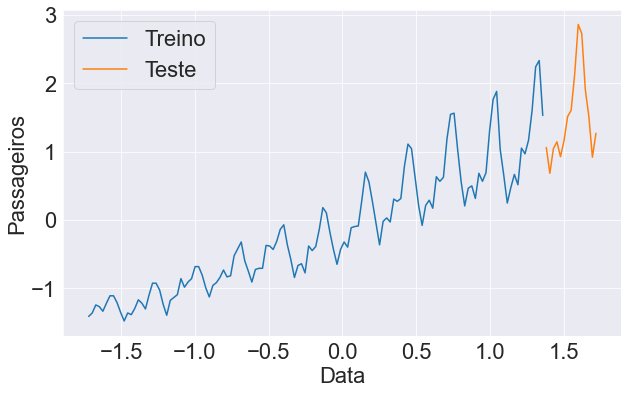

In [33]:
sns.lineplot(x=X_treino,y=y_treino,label='Treino')
sns.lineplot(x=X_teste,y=y_teste,label='Teste')

plt.ylabel("Passageiros")
plt.xlabel("Data")
plt.show()

## Construir Modelo de regressão

In [35]:
from tensorflow.keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten,Dropout

In [115]:
def build_model(X_treino, y_treino, epocas, n):
    
    #sequencia [entrada, processamento, saida]
    model = Sequential()
    
    if(n==1): #Previsao Linear
        model.add(Dense(1,activation='linear',input_dim=1,kernel_initializer='Ones',use_bias = False))
        model.compile(loss='mse', optimizer='adam')
        historico = model.fit(X_treino, y_treino)
        
    elif(n==2): # Estrutura sequencia de multiplas camadas
        model.add(Dense(8,input_dim=1,kernel_initializer='random_uniform',
                        activation='linear',use_bias = False))
        model.add(Dense(8,kernel_initializer='random_uniform',
                        activation='linear',use_bias = False))
        
        # O primeiro é o tamanho da camada seguinte, a camada de saída, neste caso. O input_dim é o tamanho da entrada.
        model.add(Dense(1,kernel_initializer='random_uniform',
                        activation='linear',use_bias = False))
        
        model.compile(loss='mse', optimizer='adam')
        historico = model.fit(X_treino, y_treino, epochs=epocas)
    
    elif(n==3): # Funcao sigmoid
        model.add(Dense(8,input_dim=1,kernel_initializer='random_uniform',
                        activation='sigmoid',use_bias = False))
        model.add(Dense(8,kernel_initializer='random_uniform',
                        activation='sigmoid',use_bias = False))
        model.add(Dense(1,kernel_initializer='random_uniform',
                        activation='linear',use_bias = False))
        
        model.compile(loss='mse', optimizer='adam')
        historico = model.fit(X_treino, y_treino, epochs=epocas) 
    
    elif(n==4): # Funcao sigmoid
        model.add(Dense(8,input_dim=1,kernel_initializer='ones',
                        activation='linear',use_bias = False))
        model.add(Dense(64,kernel_initializer='random_uniform',
                        activation='sigmoid',use_bias = False))
        model.add(Dense(1,kernel_initializer='random_uniform',
                        activation='linear',use_bias = False))
        
        model.compile(loss='mse', optimizer='adam')
        historico = model.fit(X_treino, y_treino, epochs=epocas) 
    
    model.summary()
    return model

In [74]:
def predict_train(model, scaler, X_treino,passageiros):
    y_predict = model.predict(X_treino) 
    
    d = {'tempo':X_treino,'passageiros':y_predict[:,0]}
    resultado = pd.DataFrame(data=d)
    resultado_tranf = pd.DataFrame(scaler.inverse_transform(resultado),columns=['tempo','passageiros'])
    
    sns.lineplot(x='tempo', y='passageiros',data=passageiros,label='dado_completo')
    sns.lineplot(x='tempo', y='passageiros',data=resultado_tranf,label='dados predito')

    plt.ylabel("Passageiros")
    plt.xlabel("Data")
    plt.show() 
    
    return resultado_tranf

In [78]:
def predict_test(model,scaler, X_teste, passageiros, resultado_tranf):
    y_predict_test = model.predict(X_teste)
    d = {'tempo':X_teste,'passageiros':y_predict_test[:,0]}
    
    resultado_teste = pd.DataFrame(data=d)

    resultado_teste_tranf = pd.DataFrame(scaler.inverse_transform(resultado_teste),columns=['tempo','passageiros'])
    
    sns.lineplot(x='tempo', y='passageiros',data=passageiros,label='dado_completo')
    sns.lineplot(x='tempo', y='passageiros',data=resultado_tranf,label='treino')
    sns.lineplot(x='tempo', y='passageiros',data=resultado_teste_tranf,label='teste')

    plt.ylabel("Passageiros")
    plt.xlabel("Data")
    plt.show() 
    

### Primeiro regressor (Linear)

In [55]:
model = build_model(X_treino, y_treino, 1)

5/5 [==============================] - 0s 997us/step - loss: 0.1285
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_7 (ModuleWrap (None, 1)                 1         
Total params: 1
Trainable params: 1
Non-trainable params: 0
_________________________________________________________________


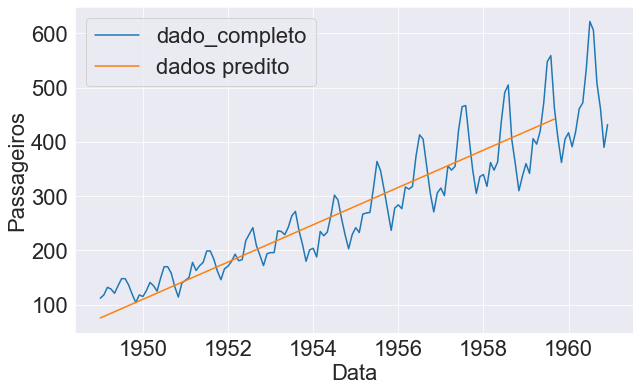

In [75]:
resultado_tranf = predict_train(model, scaler, X_treino,passageiros)

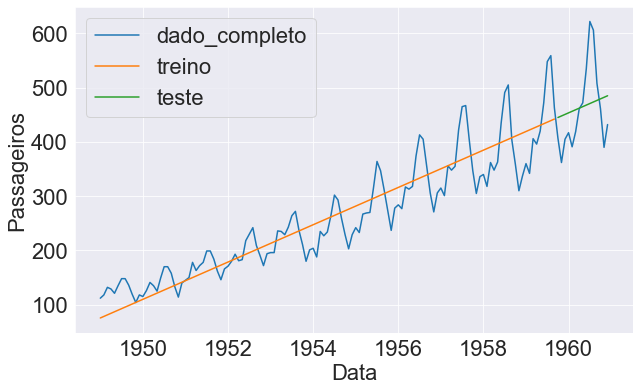

In [79]:
predict_test(model,scaler, X_teste, passageiros, resultado_tranf)

Podemos notar que para o modelo inicial, aprendemos como construir a reta de regressão porem agora precisamo ajustar os valores a curva

### Segundo Regressor (Linear + Camadas)

Criar uma estrutura maior da rede com camadas ocultas

In [92]:
model = build_model(X_treino, y_treino,200, 2)

Epoch 1/200
5/5 [==============================] - 0s 991us/step - loss: 0.8096
Epoch 2/200
5/5 [==============================] - 0s 1ms/step - loss: 0.8092
Epoch 3/200
5/5 [==============================] - 0s 997us/step - loss: 0.8087
Epoch 4/200
5/5 [==============================] - 0s 997us/step - loss: 0.8079
Epoch 5/200
5/5 [==============================] - 0s 998us/step - loss: 0.8067
Epoch 6/200
5/5 [==============================] - 0s 1ms/step - loss: 0.8050
Epoch 7/200
5/5 [==============================] - 0s 1ms/step - loss: 0.8026
Epoch 8/200
5/5 [==============================] - 0s 997us/step - loss: 0.7997
Epoch 9/200
5/5 [==============================] - 0s 1ms/step - loss: 0.7955
Epoch 10/200
5/5 [==============================] - 0s 997us/step - loss: 0.7897
Epoch 11/200
5/5 [==============================] - 0s 1ms/step - loss: 0.7822
Epoch 12/200
5/5 [==============================] - 0s 997us/step - loss: 0.7723
Epoch 13/200
5/5 [=============================

5/5 [==============================] - 0s 997us/step - loss: 0.1245
Epoch 104/200
5/5 [==============================] - 0s 998us/step - loss: 0.1231
Epoch 105/200
5/5 [==============================] - 0s 998us/step - loss: 0.1228
Epoch 106/200
5/5 [==============================] - 0s 998us/step - loss: 0.1218
Epoch 107/200
5/5 [==============================] - 0s 1ms/step - loss: 0.1217
Epoch 108/200
5/5 [==============================] - 0s 1ms/step - loss: 0.1216
Epoch 109/200
5/5 [==============================] - 0s 998us/step - loss: 0.1221
Epoch 110/200
5/5 [==============================] - 0s 1ms/step - loss: 0.1218
Epoch 111/200
5/5 [==============================] - 0s 1ms/step - loss: 0.1217
Epoch 112/200
5/5 [==============================] - 0s 998us/step - loss: 0.1216
Epoch 113/200
5/5 [==============================] - 0s 1ms/step - loss: 0.1216
Epoch 114/200
5/5 [==============================] - 0s 997us/step - loss: 0.1217
Epoch 115/200
5/5 [=====================

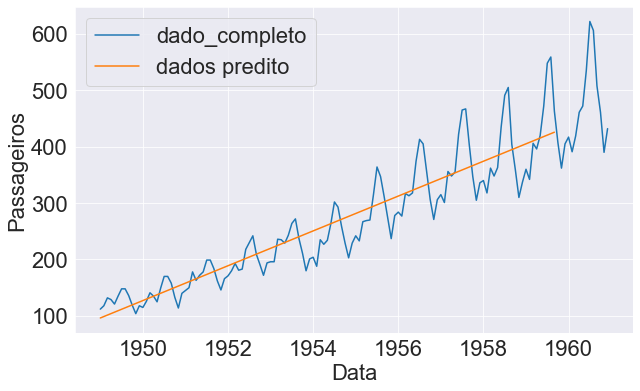

In [93]:
resultado_tranf = predict_train(model, scaler, X_treino,passageiros)

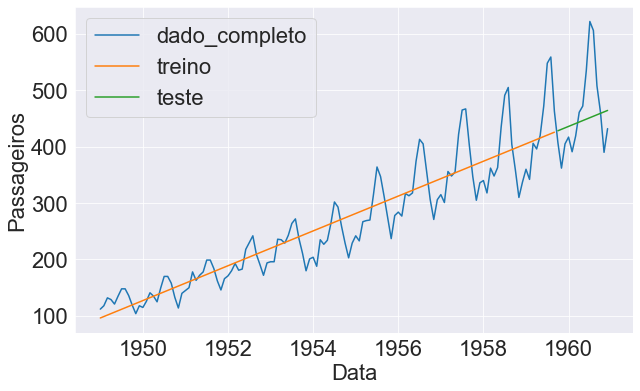

In [94]:
predict_test(model,scaler, X_teste, passageiros, resultado_tranf)

### Terceiro Regressor (Sigmoid)

In [101]:
model = build_model(X_treino, y_treino,500, 3)

Epoch 1/500
5/5 [==============================] - 0s 998us/step - loss: 0.8114
Epoch 2/500
5/5 [==============================] - 0s 998us/step - loss: 0.8077
Epoch 3/500
5/5 [==============================] - 0s 997us/step - loss: 0.8047
Epoch 4/500
5/5 [==============================] - 0s 748us/step - loss: 0.8023
Epoch 5/500
5/5 [==============================] - 0s 1ms/step - loss: 0.7995
Epoch 6/500
5/5 [==============================] - 0s 1ms/step - loss: 0.7960
Epoch 7/500
5/5 [==============================] - 0s 997us/step - loss: 0.7923
Epoch 8/500
5/5 [==============================] - 0s 996us/step - loss: 0.7899
Epoch 9/500
5/5 [==============================] - 0s 998us/step - loss: 0.7867
Epoch 10/500
5/5 [==============================] - 0s 1ms/step - loss: 0.7847
Epoch 11/500
5/5 [==============================] - 0s 997us/step - loss: 0.7830
Epoch 12/500
5/5 [==============================] - 0s 996us/step - loss: 0.7823
Epoch 13/500
5/5 [=========================

5/5 [==============================] - 0s 1ms/step - loss: 0.7587
Epoch 103/500
5/5 [==============================] - 0s 748us/step - loss: 0.7593
Epoch 104/500
5/5 [==============================] - 0s 997us/step - loss: 0.7587
Epoch 105/500
5/5 [==============================] - 0s 748us/step - loss: 0.7581
Epoch 106/500
5/5 [==============================] - 0s 997us/step - loss: 0.7569
Epoch 107/500
5/5 [==============================] - 0s 997us/step - loss: 0.7559
Epoch 108/500
5/5 [==============================] - 0s 1ms/step - loss: 0.7552
Epoch 109/500
5/5 [==============================] - 0s 998us/step - loss: 0.7541
Epoch 110/500
5/5 [==============================] - 0s 998us/step - loss: 0.7524
Epoch 111/500
5/5 [==============================] - 0s 998us/step - loss: 0.7520
Epoch 112/500
5/5 [==============================] - 0s 747us/step - loss: 0.7515
Epoch 113/500
5/5 [==============================] - 0s 748us/step - loss: 0.7506
Epoch 114/500
5/5 [===============

5/5 [==============================] - 0s 990us/step - loss: 0.6388
Epoch 201/500
5/5 [==============================] - 0s 997us/step - loss: 0.6371
Epoch 202/500
5/5 [==============================] - 0s 749us/step - loss: 0.6356
Epoch 203/500
5/5 [==============================] - 0s 998us/step - loss: 0.6341
Epoch 204/500
5/5 [==============================] - 0s 1ms/step - loss: 0.6326
Epoch 205/500
5/5 [==============================] - 0s 998us/step - loss: 0.6312
Epoch 206/500
5/5 [==============================] - 0s 907us/step - loss: 0.6295
Epoch 207/500
5/5 [==============================] - 0s 1ms/step - loss: 0.6275
Epoch 208/500
5/5 [==============================] - 0s 748us/step - loss: 0.6251
Epoch 209/500
5/5 [==============================] - 0s 997us/step - loss: 0.6245
Epoch 210/500
5/5 [==============================] - 0s 997us/step - loss: 0.6227
Epoch 211/500
5/5 [==============================] - 0s 989us/step - loss: 0.6215
Epoch 212/500
5/5 [===============

5/5 [==============================] - 0s 998us/step - loss: 0.4705
Epoch 301/500
5/5 [==============================] - 0s 749us/step - loss: 0.4687
Epoch 302/500
5/5 [==============================] - 0s 754us/step - loss: 0.4676
Epoch 303/500
5/5 [==============================] - 0s 998us/step - loss: 0.4662
Epoch 304/500
5/5 [==============================] - 0s 748us/step - loss: 0.4647
Epoch 305/500
5/5 [==============================] - 0s 755us/step - loss: 0.4629
Epoch 306/500
5/5 [==============================] - 0s 1ms/step - loss: 0.4614
Epoch 307/500
5/5 [==============================] - 0s 993us/step - loss: 0.4600
Epoch 308/500
5/5 [==============================] - 0s 990us/step - loss: 0.4586
Epoch 309/500
5/5 [==============================] - 0s 1ms/step - loss: 0.4571
Epoch 310/500
5/5 [==============================] - 0s 748us/step - loss: 0.4558
Epoch 311/500
5/5 [==============================] - 0s 756us/step - loss: 0.4543
Epoch 312/500
5/5 [===============

5/5 [==============================] - 0s 997us/step - loss: 0.3315
Epoch 401/500
5/5 [==============================] - 0s 998us/step - loss: 0.3306
Epoch 402/500
5/5 [==============================] - 0s 1ms/step - loss: 0.3297
Epoch 403/500
5/5 [==============================] - 0s 997us/step - loss: 0.3286
Epoch 404/500
5/5 [==============================] - 0s 998us/step - loss: 0.3277
Epoch 405/500
5/5 [==============================] - 0s 1ms/step - loss: 0.3266
Epoch 406/500
5/5 [==============================] - 0s 1000us/step - loss: 0.3253
Epoch 407/500
5/5 [==============================] - 0s 748us/step - loss: 0.3238
Epoch 408/500
5/5 [==============================] - 0s 748us/step - loss: 0.3226
Epoch 409/500
5/5 [==============================] - 0s 997us/step - loss: 0.3214
Epoch 410/500
5/5 [==============================] - 0s 748us/step - loss: 0.3203
Epoch 411/500
5/5 [==============================] - 0s 749us/step - loss: 0.3191
Epoch 412/500
5/5 [==============

5/5 [==============================] - 0s 998us/step - loss: 0.2390
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_29 (ModuleWra (None, 8)                 8         
_________________________________________________________________
module_wrapper_30 (ModuleWra (None, 8)                 64        
_________________________________________________________________
module_wrapper_31 (ModuleWra (None, 1)                 8         
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


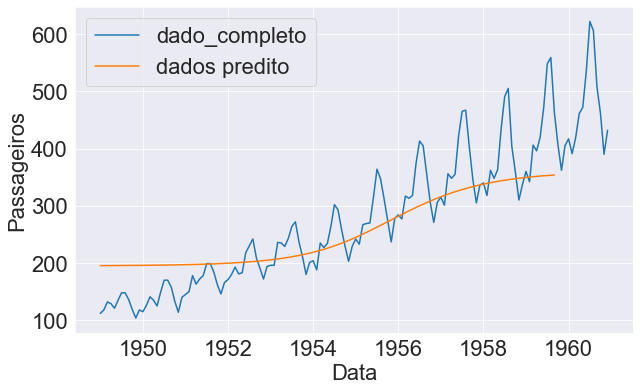

In [102]:
resultado_tranf = predict_train(model, scaler, X_treino,passageiros)

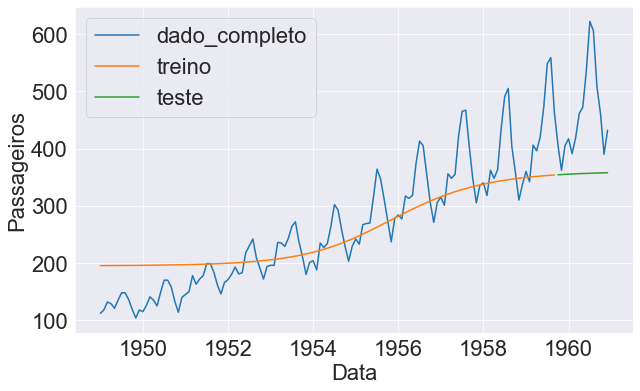

In [103]:
predict_test(model,scaler, X_teste, passageiros, resultado_tranf)

Resultado não é perfeito mas ja mostrar uma evolução na com relação a reta

## Construir Modelo com N atrasos

Construção do modelo LSTM univariado que considera X como a serie a ser predida e y como a mesma serie com 1 lag (atraso)

In [142]:
"""
model.add(Dense(8,input_dim=1,kernel_initializer='ones',
                        activation='linear',use_bias = False))
        model.add(Dense(64,kernel_initializer='random_uniform',
                        activation='sigmoid',use_bias = False))
        model.add(Dense(1,kernel_initializer='random_uniform',
                        activation='linear',use_bias = False))
        
        model.compile(loss='mse', optimizer='adam')
        historico = model.fit(X_treino, y_treino, epochs=epocas) 
"""

"\nmodel.add(Dense(8,input_dim=1,kernel_initializer='ones',\n                        activation='linear',use_bias = False))\n        model.add(Dense(64,kernel_initializer='random_uniform',\n                        activation='sigmoid',use_bias = False))\n        model.add(Dense(1,kernel_initializer='random_uniform',\n                        activation='linear',use_bias = False))\n        \n        model.compile(loss='mse', optimizer='adam')\n        historico = model.fit(X_treino, y_treino, epochs=epocas) \n"

In [141]:
def split_nlegs(vetor, n_passos):
    """
        Entrada: vetor: numero de Passageiros
                 n_passos: numero de passos no regressor
        Saida:
            X_novo: Array 2D
            y_novo: Array 1D - Nosso alvo (target)
    
    """
    # Inicializacao dos novos vetores 
    X_novo, y_novo = [],[]
    
    #percorrer o vetor de entrada e agregar valores aos novos vetores
    for i in range(n_passos, vetor.shape[0]):
        X_novo.append(list(vetor.loc[i-n_passos:i-1]))
        y_novo.append(vetor.loc[i])
    X_novo, y_novo = np.array(X_novo),np.array(y_novo)
    
    return X_novo, y_novo

In [139]:
def predict_lstm(model, X_treino_novo, X_teste_novo):
    y_predict_novo = model.predict(X_treino_novo)
    y_predict_teste_novo = model.predict(X_teste_novo)
    
    
    sns.lineplot(x='tempo',y=y_treino_novo,data=passageiros[1:129],label='treino')
    sns.lineplot(x='tempo',y=pd.DataFrame(y_predict_novo)[0],data=passageiros[1:129],label='predicao treino')
    
    resultado = pd.DataFrame(y_predict_teste_novo)[0]
    sns.lineplot(x='tempo',y=y_teste_novo,data=passageiros[130:144],label='teste')
    sns.lineplot(x='tempo',y=resultado.values,data=passageiros[130:144],label='previsao')
    
    plt.show()

In [117]:
vetor_treino =pd.DataFrame(y_treino)[0]
vetor_teste =pd.DataFrame(y_teste)[0]

X_treino_novo, y_treino_novo = split_nlegs(vetor_treino, 1)
X_teste_novo, y_teste_novo = split_nlegs(vetor_teste, 1)

In [118]:
X_treino_novo[0:5], y_treino_novo[0:5]

(array([[-1.40777884],
        [-1.35759023],
        [-1.24048348],
        [-1.26557778],
        [-1.33249593]]),
 array([-1.35759023, -1.24048348, -1.26557778, -1.33249593, -1.21538918]))

In [119]:
X_teste_novo[0:5], y_teste_novo[0:5]

(array([[1.05982773],
        [0.68341317],
        [1.04309819],
        [1.14347541],
        [0.92599144]]),
 array([0.68341317, 1.04309819, 1.14347541, 0.92599144, 1.16020494]))

In [120]:
model = build_model(X_treino_novo, y_treino_novo,200,4)

Epoch 1/200
4/4 [==============================] - 0s 1ms/step - loss: 0.7945
Epoch 2/200
4/4 [==============================] - 0s 1ms/step - loss: 0.7580
Epoch 3/200
4/4 [==============================] - 0s 1ms/step - loss: 0.7343
Epoch 4/200
4/4 [==============================] - 0s 1ms/step - loss: 0.7134
Epoch 5/200
4/4 [==============================] - 0s 2ms/step - loss: 0.6936
Epoch 6/200
4/4 [==============================] - 0s 1ms/step - loss: 0.6682
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 0.6432
Epoch 8/200
4/4 [==============================] - 0s 1ms/step - loss: 0.6183
Epoch 9/200
4/4 [==============================] - 0s 2ms/step - loss: 0.5901
Epoch 10/200
4/4 [==============================] - 0s 997us/step - loss: 0.5591
Epoch 11/200
4/4 [==============================] - 0s 2ms/step - loss: 0.5259
Epoch 12/200
4/4 [==============================] - 0s 998us/step - loss: 0.4895
Epoch 13/200
4/4 [==============================] - 0s 1m

4/4 [==============================] - 0s 997us/step - loss: 0.0625
Epoch 104/200
4/4 [==============================] - 0s 997us/step - loss: 0.0625
Epoch 105/200
4/4 [==============================] - 0s 996us/step - loss: 0.0627
Epoch 106/200
4/4 [==============================] - 0s 2ms/step - loss: 0.0625
Epoch 107/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0625
Epoch 108/200
4/4 [==============================] - 0s 997us/step - loss: 0.0624
Epoch 109/200
4/4 [==============================] - 0s 997us/step - loss: 0.0625
Epoch 110/200
4/4 [==============================] - 0s 998us/step - loss: 0.0624
Epoch 111/200
4/4 [==============================] - 0s 998us/step - loss: 0.0625
Epoch 112/200
4/4 [==============================] - 0s 1ms/step - loss: 0.0626
Epoch 113/200
4/4 [==============================] - 0s 997us/step - loss: 0.0626
Epoch 114/200
4/4 [==============================] - 0s 997us/step - loss: 0.0624
Epoch 115/200
4/4 [=================

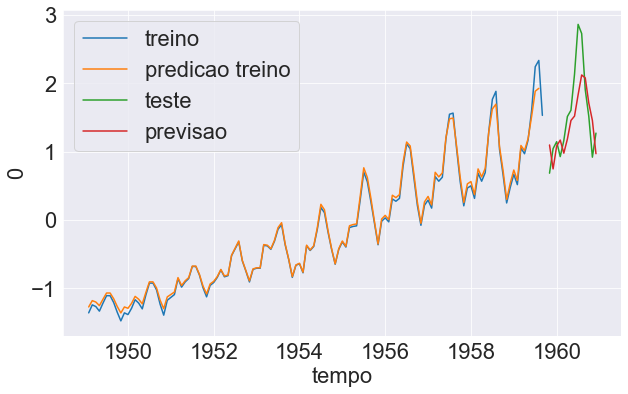

In [140]:
predict_lstm(model, X_treino_novo, X_teste_novo)